# 0. Import data
## Data formatting as pandas dataframe

 This small section imports data from kaggle since it is already formatted.

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from kagglehub import KaggleDatasetAdapter
from tabulate import tabulate

# Set the path to the file you'd like to load
file_path = "uci-secom.csv"

# Load the latest version
raw_data_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "paresh2047/uci-semcom",
  file_path
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

def pretty_table(df=pd.DataFrame()):
  print(tabulate(df, headers='keys', tablefmt='psql'))

print("First 5 records:")
pretty_table(raw_data_df.head())

<ipython-input-3-9881beaf97bc>:13: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  raw_data_df = kagglehub.load_dataset(


100%|██████████| 2.03M/2.03M [00:00<00:00, 102MB/s]

Extracting zip of uci-secom.csv...


First 5 records:
+----+---------------------+---------+---------+---------+----------+--------+-----+----------+--------+--------+---------+---------+--------+---------+------+---------+---------+---------+--------+---------+---------+--------+----------+---------+----------+----------+--------+--------+--------+---------+--------+--------+--------+---------+--------+---------+---------+---------+---------+---------+---------+-------+-------+------+---------+---------+---------+---------+--------+---------+------+---------+---------+------+-------+-------+------+--------+--------+--------+----------+---------+---------+---------+---------+---------+---------+---------+--------+---------+------+---------+---------+---------+---------+------+---------+---------+---------+---------+---------+---------+---------+---------+--------+--------+------+--------+--------+---------+--------+---------+---------+---------+---------+---------+---------+---------+------+---------+---------+---------+-

0.1 Shape of the raw_data_df

In [ ]:
print("raw_data_df shape (rows, columns):", raw_data_df.shape)

raw_data_df shape (rows, columns): (1567, 592)


# 1. General data information

## 1.1 Dates

### 1.1.1 Begin date and end date

In [ ]:
# beginning date and end date
begin_date, end_date = min(raw_data_df['Time']), max(raw_data_df['Time'])
print('Begin date: ', begin_date)
print('End date: ', end_date)

Begin date:  2008-01-08 02:02:00
End date:  2008-12-10 18:47:00


### 1.1.2 Datapoints per year and month

In [ ]:
# histogram
tmp_dates = pd.to_datetime(raw_data_df['Time'], errors='coerce')
raw_data_df['Time'] = pd.DataFrame(tmp_dates)
times = raw_data_df['Time'].groupby([raw_data_df['Time'].dt.year, raw_data_df['Time'].dt.month]).agg({'count'})
result_times_df = pd.DataFrame(times).rename(columns={'count': 'count datapoints'})
pretty_table(result_times_df)

+------------+--------------------+
|            |   count datapoints |
|------------+--------------------|
| (2008, 1)  |                 51 |
| (2008, 2)  |                 98 |
| (2008, 3)  |                 50 |
| (2008, 4)  |                 49 |
| (2008, 5)  |                 62 |
| (2008, 6)  |                 67 |
| (2008, 7)  |                114 |
| (2008, 8)  |                471 |
| (2008, 9)  |                413 |
| (2008, 10) |                123 |
| (2008, 11) |                 35 |
| (2008, 12) |                 34 |
+------------+--------------------+


### 1.1.3 Failures per month

In [ ]:
failures_per_month = raw_data_df.groupby([raw_data_df['Time'].dt.year, raw_data_df['Time'].dt.month, raw_data_df['Pass/Fail']]).agg({'count'})
pretty_table(failures_per_month.iloc[:, :1])

+----------------+---------------------+
|                |   ('Time', 'count') |
|----------------+---------------------|
| (2008, 1, -1)  |                  48 |
| (2008, 1, 1)   |                   3 |
| (2008, 2, -1)  |                  93 |
| (2008, 2, 1)   |                   5 |
| (2008, 3, -1)  |                  49 |
| (2008, 3, 1)   |                   1 |
| (2008, 4, -1)  |                  46 |
| (2008, 4, 1)   |                   3 |
| (2008, 5, -1)  |                  55 |
| (2008, 5, 1)   |                   7 |
| (2008, 6, -1)  |                  61 |
| (2008, 6, 1)   |                   6 |
| (2008, 7, -1)  |                  98 |
| (2008, 7, 1)   |                  16 |
| (2008, 8, -1)  |                 433 |
| (2008, 8, 1)   |                  38 |
| (2008, 9, -1)  |                 396 |
| (2008, 9, 1)   |                  17 |
| (2008, 10, -1) |                 117 |
| (2008, 10, 1)  |                   6 |
| (2008, 11, -1) |                  33 |
| (2008, 11, 1) 

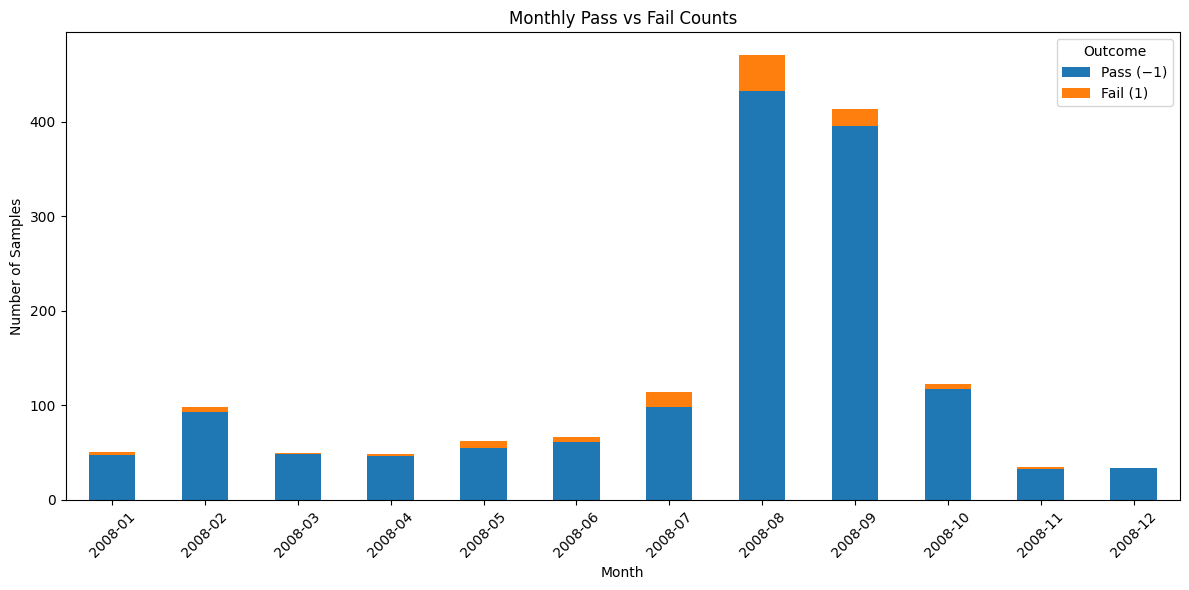

In [ ]:
# 1.1.3 Visualise Failures per Month (stacked bar)
import matplotlib.pyplot as plt

# Recompute counts per (year, month, Pass/Fail)
fpm = (
    raw_data_df
    .groupby([
        raw_data_df['Time'].dt.year.rename('year'),
        raw_data_df['Time'].dt.month.rename('month'),
        raw_data_df['Pass/Fail'].rename('pass_fail')
    ])
    .size()
    .to_frame('count')
    .reset_index()
)

# Pivot so pass_fail values become columns
counts = (
    fpm
    .pivot(index=['year','month'], columns='pass_fail', values='count')
    .fillna(0)
    .rename(columns={-1: 'Pass (−1)', 1: 'Fail (1)'})
)

# Format the index as "YYYY-MM"
counts.index = counts.index.map(lambda ym: f"{int(ym[0])}-{int(ym[1]):02d}")

# Plot stacked bar
fig, ax = plt.subplots(figsize=(12,6))
counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Samples')
ax.set_title('Monthly Pass vs Fail Counts')
ax.legend(title='Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-20-89d607d22393>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fr['month'].astype(str), rotation=45)


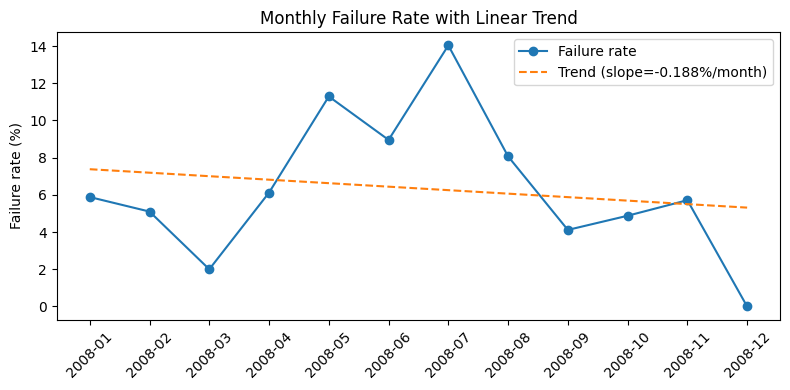

In [ ]:
# 1.1.4 Trend in monthly failure rate

import numpy as np
import matplotlib.pyplot as plt

# reuse 'fr' from Cell 2.19 (month, fail_rate_pct)
# if 'fr' isn’t in memory, recompute it:
fr = (
    raw_data_df
    .assign(month=raw_data_df['Time'].dt.to_period('M'))
    .groupby('month')['Pass/Fail']
    .apply(lambda x: (x==1).mean()*100)
    .to_frame('failure_rate_pct')
    .reset_index()
)

# convert month to numeric index for regression
fr['month_ordinal'] = np.arange(len(fr))
# linear fit
slope, intercept = np.polyfit(fr['month_ordinal'], fr['failure_rate_pct'], 1)

# plot failure rate + trend line
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(fr['month'].astype(str), fr['failure_rate_pct'], marker='o', label='Failure rate')
ax.plot(fr['month'].astype(str),
        intercept + slope*fr['month_ordinal'],
        color='C1', linestyle='--', label=f"Trend (slope={slope:.3f}%/month)")
ax.set_xticklabels(fr['month'].astype(str), rotation=45)
ax.set_ylabel('Failure rate (%)')
ax.set_title('Monthly Failure Rate with Linear Trend')
ax.legend()
plt.tight_layout()
plt.show()


# 2. Exploratory data analysis (EDA)

## 2.1 How many missing values?

### 2.2.1 Missing values per column

+----+---------------------+-----------------+-----------------------------+---------------------+
|    |   count_missing_val |   total_columns |   total_columns_relative(%) |   cumulative_sum(%) |
|----+---------------------+-----------------+-----------------------------+---------------------|
|  0 |                   6 |             100 |                   16.8919   |             16.8919 |
|  1 |                   1 |              92 |                   15.5405   |             32.4324 |
|  2 |                   2 |              84 |                   14.1892   |             46.6216 |
|  3 |                   0 |              54 |                    9.12162  |             55.7432 |
|  4 |                   9 |              48 |                    8.10811  |             63.8514 |
|  5 |                  24 |              43 |                    7.26351  |             71.1149 |
|  6 |                   3 |              24 |                    4.05405  |             75.1689 |
|  7 |    

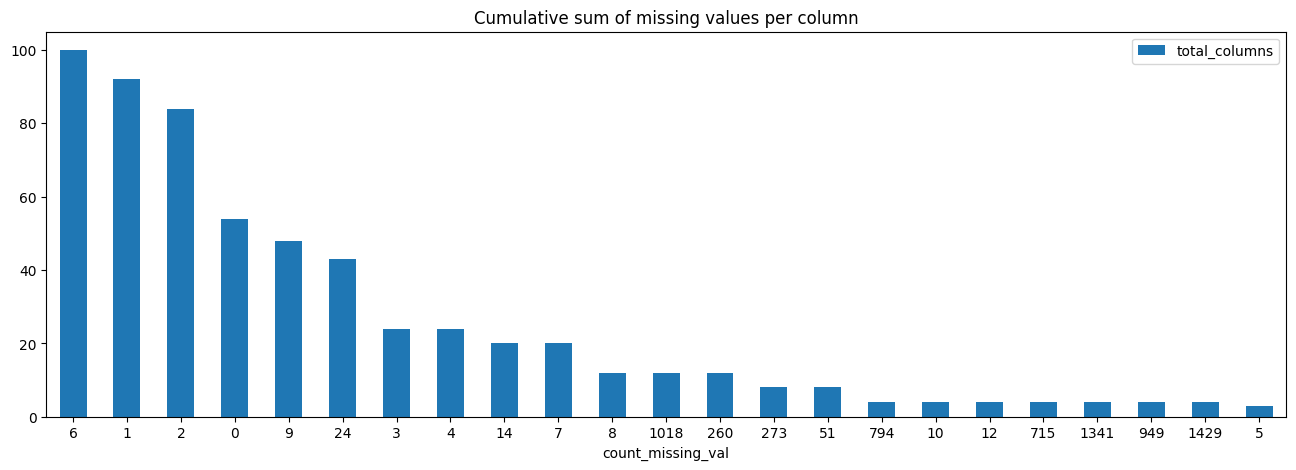

In [ ]:
# count missing values per each column
total_missing_col_count_df = raw_data_df.isna().sum().to_frame().reset_index()

# rename columns in data frame result
total_missing_col_count_df = total_missing_col_count_df.rename(columns={'index': 'features', 0: 'count_missing_val'})

# plot result
#total_missing_col_count_df.plot.bar(x='features', y='count_missing_val', rot=0)

# Compute cumulative sum of missing values
cumulative_sum_missing_values = total_missing_col_count_df.groupby(['count_missing_val']).size().reset_index(name='counts')
cumulative_sum_missing_values = cumulative_sum_missing_values.rename(columns={'count_missing_val': 'count_missing_val', 'counts': 'total_columns'})
cumulative_sum_missing_values = cumulative_sum_missing_values.sort_values(by=['total_columns'], ascending=False)

# compute rellative percentajes
total_columns = cumulative_sum_missing_values['total_columns'].sum()
cumulative_sum_missing_values['total_columns_relative(%)'] = cumulative_sum_missing_values['total_columns']/total_columns*100
cumulative_sum_missing_values = cumulative_sum_missing_values.reset_index(drop=True)
# compute cumulative sum by relative count
cumulative_sum_missing_values['cumulative_sum(%)'] = cumulative_sum_missing_values['total_columns_relative(%)'].cumsum(axis=0)

#print(cumulative_sum_missing_values)
pretty_table(cumulative_sum_missing_values)

# plot cumulative result
p = cumulative_sum_missing_values.plot.bar(x='count_missing_val', y='total_columns', rot=0, title='Cumulative sum of missing values per column', figsize=(16,5))
#p.bar_label(p)


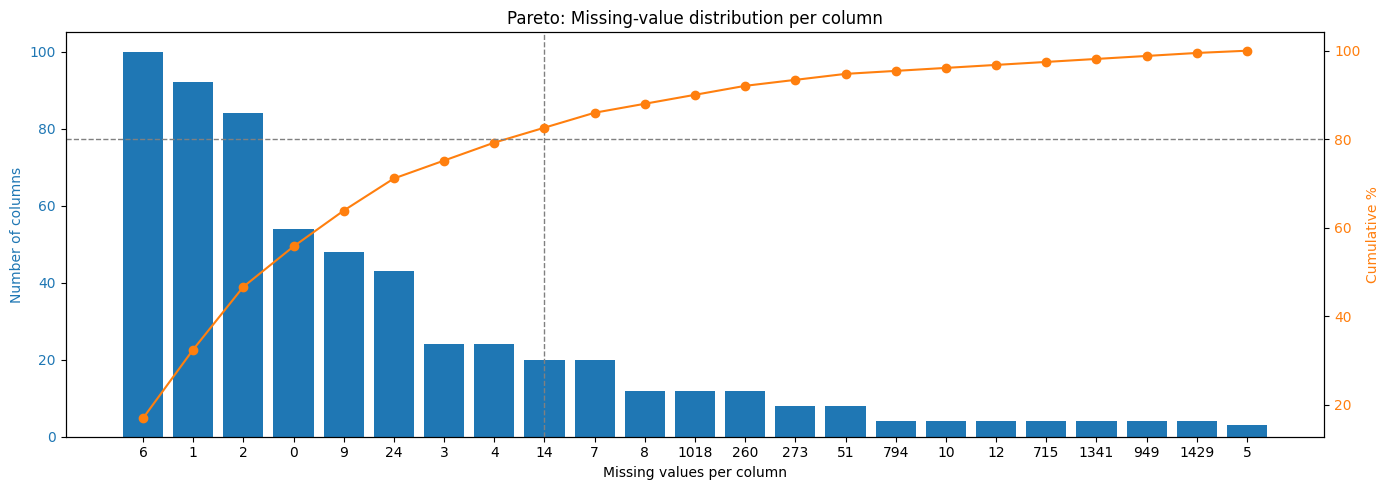

In [ ]:
# Pareto chart (reuse cumulative_sum_missing_values)
import matplotlib.pyplot as plt

# rename for convenience
pareto_df = cumulative_sum_missing_values.copy()

# ensure sorted by descending total_columns
pareto_df = pareto_df.sort_values('total_columns', ascending=False).reset_index(drop=True)

# strings for x‐axis
x = pareto_df['count_missing_val'].astype(str)

fig, ax1 = plt.subplots(figsize=(14,5))

# bar: number of columns
ax1.bar(x, pareto_df['total_columns'], color='C0', label='# columns')
ax1.set_xlabel('Missing values per column')
ax1.set_ylabel('Number of columns', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

# twin axis for cumulative %
ax2 = ax1.twinx()
ax2.plot(x, pareto_df['cumulative_sum(%)'], color='C1', marker='o', label='Cumulative %')
ax2.set_ylabel('Cumulative %', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

# draw 80% threshold line
ax2.axhline(80, color='grey', linestyle='--', linewidth=1)
# find first x where cum pct ≥80
idx80 = pareto_df[pareto_df['cumulative_sum(%)'] >= 80].index.min()
ax1.axvline(idx80, color='grey', linestyle='--', linewidth=1)

plt.title('Pareto: Missing‐value distribution per column')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 2.2.2 Missing value per row

In [ ]:
# TODO: DO exactly as done for columns.
total_missing_row_count_df = raw_data_df.isnull().sum(axis = 1).to_frame().reset_index()
total_missing_row_count_df = total_missing_row_count_df.rename(columns={'index': 'rows', 0: 'count_missing_val'})

# Compute cumulative sum of missing values
cumulative_sum_missing_values_row = total_missing_row_count_df.groupby(['count_missing_val']).size().reset_index(name='counts')
cumulative_sum_missing_values_row = cumulative_sum_missing_values_row.rename(columns={'count_missing_val': 'count_missing_val', 'counts': 'total_rows'})
cumulative_sum_missing_values_row = cumulative_sum_missing_values_row.sort_values(by=['total_rows'], ascending=False)
pretty_table(cumulative_sum_missing_values_row)


+----+---------------------+--------------+
|    |   count_missing_val |   total_rows |
|----+---------------------+--------------|
|  9 |                  28 |          264 |
|  7 |                  24 |          239 |
|  5 |                  20 |          224 |
|  3 |                  16 |          170 |
|  2 |                  12 |          134 |
| 11 |                  32 |          132 |
| 13 |                  36 |          113 |
| 15 |                  40 |           75 |
| 17 |                  44 |           49 |
|  1 |                   8 |           49 |
| 19 |                  48 |           33 |
| 21 |                  52 |           12 |
|  0 |                   4 |            9 |
| 12 |                  35 |            8 |
| 23 |                  60 |            8 |
| 14 |                  39 |            5 |
| 10 |                  31 |            5 |
| 29 |                  84 |            4 |
| 24 |                  64 |            3 |
| 33 |                  96 |    

In [ ]:
# 2.1.3 Identify & flag features with >60% missing values

# 1. Compute missing‐value statistics for each feature
feature_missing_statistics = (
    raw_data_df
    .isna()
    .sum()
    .to_frame(name='missing_count')
    .reset_index()
    .rename(columns={'index': 'feature_name'})
)
feature_missing_statistics['missing_percentage'] = (
    feature_missing_statistics['missing_count']
    / len(raw_data_df)
    * 100
)

# 2. Select features where more than 60% of entries are missing
features_with_high_missingness = feature_missing_statistics[
    feature_missing_statistics['missing_percentage'] > 60
].sort_values('missing_percentage', ascending=False)

# 3. Display results
print("Features with more than 60% missing values:\n")
pretty_table(features_with_high_missingness)

print(f"\nTotal number of flagged features: {len(features_with_high_missingness)}")


Features with more than 60% missing values:

+-----+----------------+-----------------+----------------------+
|     |   feature_name |   missing_count |   missing_percentage |
|-----+----------------+-----------------+----------------------|
| 159 |            158 |            1429 |              91.1934 |
| 158 |            157 |            1429 |              91.1934 |
| 293 |            292 |            1429 |              91.1934 |
| 294 |            293 |            1429 |              91.1934 |
| 493 |            492 |            1341 |              85.5775 |
| 359 |            358 |            1341 |              85.5775 |
|  86 |             85 |            1341 |              85.5775 |
| 221 |            220 |            1341 |              85.5775 |
| 245 |            244 |            1018 |              64.9649 |
| 110 |            109 |            1018 |              64.9649 |
| 111 |            110 |            1018 |              64.9649 |
| 112 |            111 |       

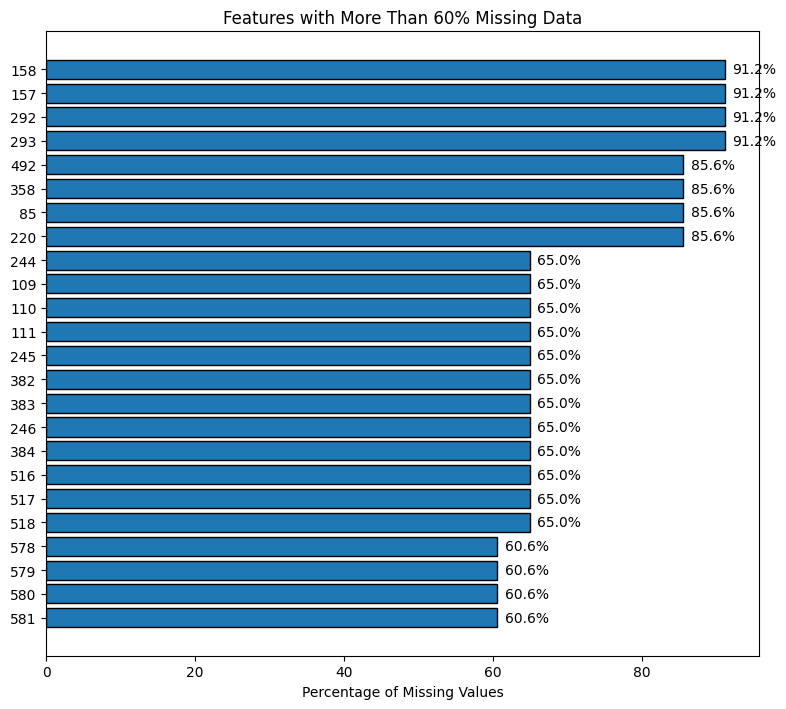

In [ ]:
# 2.1.4 Visualise features with >60% missing values

import matplotlib.pyplot as plt

# reuse the DataFrame from Cell 2.26
high_missing_df = features_with_high_missingness.copy()

# create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, max(6, len(high_missing_df)*0.3)))
ax.barh(
    high_missing_df['feature_name'],
    high_missing_df['missing_percentage'],
    color='C0',
    edgecolor='k'
)
ax.set_xlabel('Percentage of Missing Values')
ax.set_title('Features with More Than 60% Missing Data')
ax.invert_yaxis()  # show highest percentages at the top

# annotate each bar with its missing % value
for idx, pct in enumerate(high_missing_df['missing_percentage']):
    ax.text(pct + 1, idx, f"{pct:.1f}%", va='center')

plt.tight_layout()
plt.show()


## 2.2 How many -1s and 1s?

In [ ]:
total_pass_count = raw_data_df['Pass/Fail'].value_counts().get(-1, 0)
total_fail_count = raw_data_df['Pass/Fail'].value_counts().get(1, 0)
total_samples = len(raw_data_df['Pass/Fail'])

dict_res = {'Values': ['-1 (Pass)', '1 (Fail)', 'Total'],
            'Absolute count(unit)': [total_pass_count, total_fail_count, total_samples],
            'Relative count(%)': [total_pass_count/total_samples*100,
                                   total_fail_count/total_samples*100,
                                   (total_fail_count + total_pass_count)/total_samples*100
                                  ]
            }
dict_res_df = pd.DataFrame(dict_res)

pretty_table(dict_res_df)

+----+-----------+------------------------+---------------------+
|    | Values    |   Absolute count(unit) |   Relative count(%) |
|----+-----------+------------------------+---------------------|
|  0 | -1 (Pass) |                   1463 |            93.3631  |
|  1 | 1 (Fail)  |                    104 |             6.63689 |
|  2 | Total     |                   1567 |           100       |
+----+-----------+------------------------+---------------------+


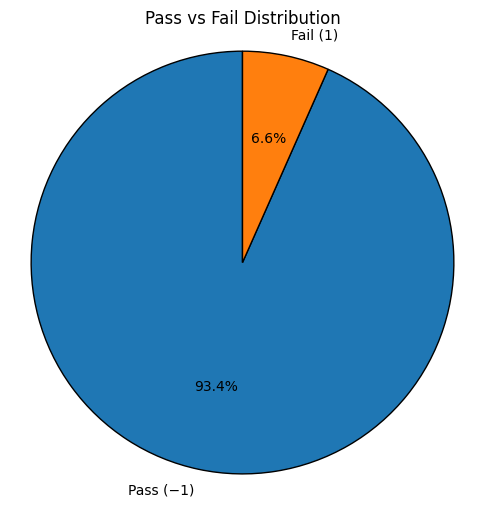

In [ ]:
#Pie chart of Pass vs Fail
import matplotlib.pyplot as plt

# compute counts
counts = raw_data_df['Pass/Fail'].value_counts().sort_index()
labels = ['Pass (−1)', 'Fail (1)']
sizes  = [counts.get(-1, 0), counts.get(1, 0)]

# plot
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'k'}
)
ax.axis('equal')  # keep as circle
ax.set_title("Pass vs Fail Distribution")
plt.show()

## 2.3 How many repeated rows?

In [ ]:
result_repeated_rows = pd.DataFrame(raw_data_df.iloc[:,1:-1].duplicated()).value_counts().get(True,0)
print(f"\nRepeated rows: {result_repeated_rows}")


Repeated rows: 0


In [ ]:
# 2.4 Approx. number of publications on SECOM dataset
import requests
r = requests.get('https://api.crossref.org/works?query=SECOM dataset&rows=0')
pubs = r.json()['message']['total-results']
print("≈ publications mentioning “SECOM dataset”:", pubs)


≈ publications mentioning “SECOM dataset”: 517680


3.1 Zero-nonzero variance

In [ ]:
# 3.1 Flag features with zero‐ and near‐zero variance

# 1. Define threshold for “near‐zero” variance
near_zero_variance_threshold = 1e-6

# 2. Compute variance of each numeric sensor (exclude the Pass/Fail target)
sensor_variances = (
    raw_data_df
    .select_dtypes(include='number')
    .drop(columns=['Pass/Fail'])
    .var()
)

# 3. Identify features with exactly zero variance and those just above zero
zero_variance_features = sensor_variances[sensor_variances == 0].index.to_list()
near_zero_variance_features = sensor_variances[
    (sensor_variances > 0) & (sensor_variances <= near_zero_variance_threshold)
].index.to_list()

# 4. Print counts and examples
print(f"Zero‐variance features:     {len(zero_variance_features)}")
print(f"Near‐zero‐variance features: {len(near_zero_variance_features)}\n")

print("Example zero‐variance features:")
print(zero_variance_features[:10], "\n")

print("Example near‐zero‐variance features:")
print(near_zero_variance_features[:10])


Zero‐variance features:     116
Near‐zero‐variance features: 11

Example zero‐variance features:
['5', '13', '42', '49', '52', '69', '97', '141', '149', '178'] 

Example near‐zero‐variance features:
['94', '95', '100', '101', '104', '278', '357', '358', '376', '377']


3.2 Outlier Detection

In [ ]:
# 3.2 Outlier detection by 3-sigma rule with thresholds and statistics

import pandas as pd

# 1. Prepare list to collect statistics
three_sigma_outlier_stats = []

# 2. Identify all numeric sensor columns (exclude the Pass/Fail target)
sensor_columns = (
    raw_data_df
    .select_dtypes(include='number')
    .drop(columns=['Pass/Fail'])
    .columns
)

# 3. Compute 3-sigma stats for each sensor
for sensor in sensor_columns:
    values = raw_data_df[sensor].dropna()
    mean_val = values.mean()
    std_val  = values.std()
    lower_limit = mean_val - 3 * std_val
    upper_limit = mean_val + 3 * std_val

    # calculate percentage of outliers beyond ±3σ
    outlier_pct = ((values < lower_limit) | (values > upper_limit)).mean() * 100

    three_sigma_outlier_stats.append({
        'feature_name': sensor,
        'mean': mean_val,
        'std_dev': std_val,
        '3sigma_lower_bound': lower_limit,
        '3sigma_upper_bound': upper_limit,
        'outlier_pct_3sigma': outlier_pct
    })

# 4. Build DataFrame and sort descending by outlier percentage
three_sigma_outlier_df = (
    pd.DataFrame(three_sigma_outlier_stats)
      .sort_values(by='outlier_pct_3sigma', ascending=False)
      .reset_index(drop=True)
)

# 5. Display the top 10 sensors by outlier rate
print("Top 10 sensors by 3-sigma outlier percentage (with thresholds):\n")
pretty_table(three_sigma_outlier_df.head(10))


Top 10 sensors by 3-sigma outlier percentage (with thresholds):

+----+----------------+------------+-------------+----------------------+----------------------+----------------------+
|    |   feature_name |       mean |     std_dev |   3sigma_lower_bound |   3sigma_upper_bound |   outlier_pct_3sigma |
|----+----------------+------------+-------------+----------------------+----------------------+----------------------|
|  0 |             38 |  86.8366   |   0.446756  |           85.4963    |            88.1768   |              4.53384 |
|  1 |            576 |   5.56375  |  16.9214    |          -45.2004    |            56.3279   |              4.46713 |
|  2 |            574 |   9.16231  |  26.9202    |          -71.5981    |            89.9228   |              4.3395  |
|  3 |            577 |  16.6424   |  12.4853    |          -20.8134    |            54.0982   |              3.9566  |
|  4 |            573 |   0.345636 |   0.248478  |           -0.399798  |             1.09107  

# Stratified K-Fold, where k=10



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# New Section